In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import time
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image  # Importe a classe Image da biblioteca PIL
# import helper
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader

In [107]:
import pandas as pd

# Leia o arquivo Excel
df = pd.read_excel('C:/Users/Karol/Documents/Python projeto/microscopy_ground_truth.xlsx')

# Exiba as primeiras linhas do DataFrame para verificar se os dados foram lidos corretamente
print(df.head())



  nome_da_imagem    tipo
0       n001.tif  Normal
1       n002.tif  Normal
2       n003.tif  Normal
3       n004.tif  Normal
4       n005.tif  Normal


In [108]:
print(df.columns)

Index(['nome_da_imagem', 'tipo'], dtype='object')


In [109]:
classes = ('Benign', 'InSitu', 'Invasive', 'Normal')

In [110]:
# Diretório onde estão localizadas as imagens
diretorio_imagens = 'C:/Users/Karol/Documents/Python projeto/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/BACH_Preparado/200x200_pb/'

# Crie uma lista de caminhos para as imagens
image_paths = [diretorio_imagens + nome_da_imagem for nome_da_imagem in df['nome_da_imagem']]


In [111]:
from sklearn.preprocessing import LabelEncoder

# Instancie o LabelEncoder
label_encoder = LabelEncoder()

# Atribua um número único a cada tipo (rótulo)
df['tipo_numerico'] = label_encoder.fit_transform(df['tipo'])

# Exiba as primeiras linhas do DataFrame com os tipos numéricos
print(df[['tipo', 'tipo_numerico']].head())


     tipo  tipo_numerico
0  Normal              3
1  Normal              3
2  Normal              3
3  Normal              3
4  Normal              3


In [112]:
PATH='C:/Users/Karol/Documents/Python projeto/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/BACH_Preparado/200x200_pb'


In [113]:
transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4


In [114]:
dataset = ImageFolder(PATH, transform=transform)

In [115]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)



In [116]:
def imshow(img): 
    img = (img * 0.5) + 0.5  # desnormalizar imagens
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

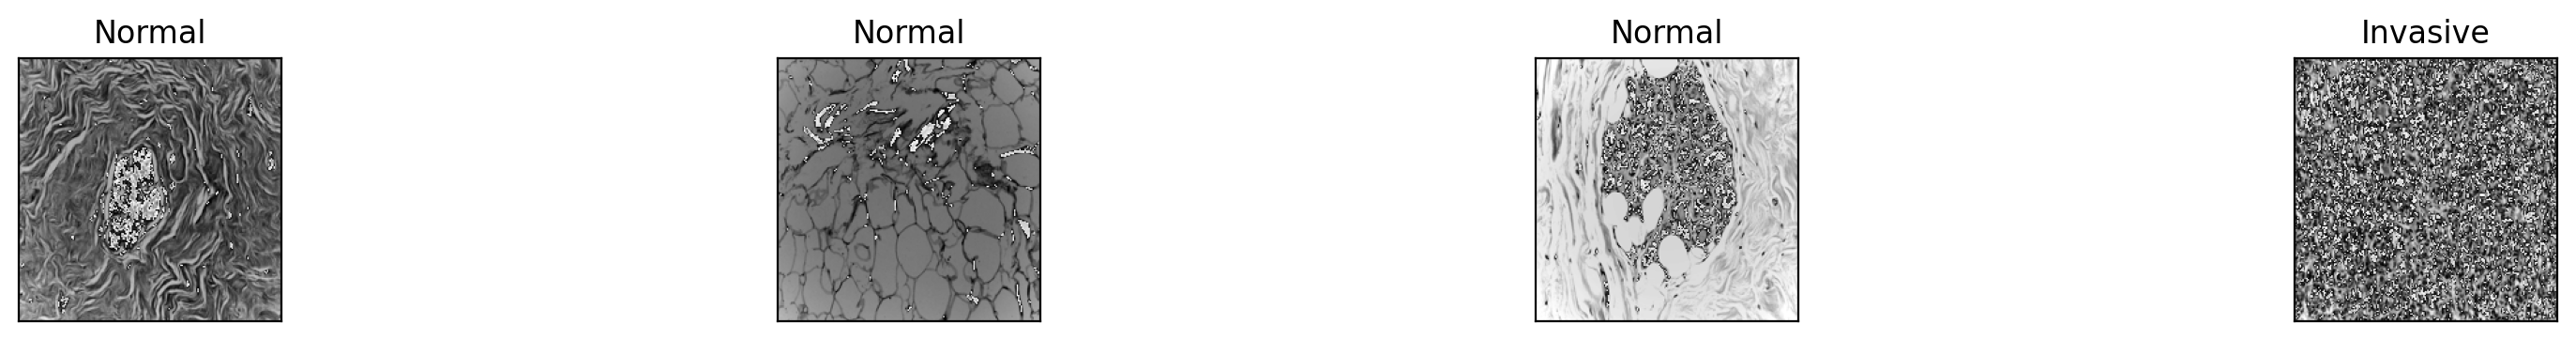

In [117]:
# Um batch de dados de treino
dataiter = iter(dataloader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 8 // 2, idx + 1, xticks=[], yticks=[])  # Correção na divisão
    image = images[idx].numpy().transpose((1, 2, 0))  # Reorganize as dimensões da imagem
    image_pil = Image.fromarray((image * 255).astype(np.uint8))  # Converte para objeto PIL
    plt.imshow(image_pil)  # Exibe a imagem PIL
    ax.set_title(classes[labels[idx]])

plt.show()

In [118]:
images[0].shape

torch.Size([3, 200, 200])

In [119]:
labels

tensor([3, 3, 3, 2])

In [120]:
inicio = time.time()
fim = time.time()

In [121]:
print (fim - inicio)

0.0


Para calcular o tamanho espacial da saida podemos usar a fórmula ((N − F + 2P) / S) + 1.
onde:
N : Dimensão da imagem de entrada
F : Dimensão do Filtro
P : O padding
S : O stride
Lembrando que um maxpooling de (kernel_size = 2,stride = 2) diminui pela metade a dimensão da imagem nos eixos x e y


In [122]:
label_encoder = LabelEncoder()

df['tipo_numerico'] = label_encoder.fit_transform(df['tipo'])

# Defina sua arquitetura CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # com base nas dimensões da imagem de entrada (200x200)
        self.fc_input_size = 32 * 50 * 50  # (32 canais * 50 * 50 pixels)
        
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 4)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc_input_size)  # Achatamento para as camadas fully connected
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn = CNN()

In [123]:
#Caso esteja disponível, processar na GPU
USAR_GPU = True 

In [124]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

# train_loader=torch.utils.data.DataLoader(dataset, batch_size=4)
# optimizer = optim.Adam(cnn.parameters(), lr=0.01)


In [125]:
use_cuda = USAR_GPU and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print('Usar GPU: ', USAR_GPU)
print('GPU disponivel:', torch.cuda.is_available())
print('Processando em:', device )

#Seta onde será executada
cnn.to(device)

Usar GPU:  True
GPU disponivel: False
Processando em: cpu


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=80000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [126]:
x = []
y_acertos = []
y_loss = []
epochs = 40
inicio = time.time()

# Inicie o treinamento
for epoch in range(epochs):
    total_loss = 0
    total_acertos = 0
    
    # Itere pelo DataLoader
    for images, labels in dataloader:
        #Coloca os dados no dispositivo de processamento
        images, labels = images.to(device), labels.to(device)

        # Restante do código para treinamento da rede
        preds = cnn(images)
        loss = F.cross_entropy(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Cálculos de acertos e perda
        acertos = preds.argmax(dim=1).eq(labels).sum().item()
        total_loss += loss.item()
        total_acertos += acertos
    
    # Armazene as métricas para plotagem ou acompanhamento
    x.append(epoch)
    y_acertos.append(total_acertos)
    y_loss.append(total_loss)

    # Exiba o progresso
    print('epoch:', epoch, end='')
    print('\tloss: ', round(total_loss, 2), end='')
    print('\tacertos:', total_acertos, f'({round(total_acertos * 100 / len(df), 2)}%)')

print("Treinamento concluído!")
fim = time.time()
tempo = round(fim - inicio, 2)
minutos = tempo // 60
segundos = round (tempo % 60,2)
print(minutos,'minutos e' , segundos, 'segundos' )
print(tempo, 'segundos')


epoch: 0	loss:  139.08	acertos: 99 (24.75%)
epoch: 1	loss:  137.41	acertos: 117 (29.25%)
epoch: 2	loss:  134.19	acertos: 153 (38.25%)
epoch: 3	loss:  124.75	acertos: 179 (44.75%)
epoch: 4	loss:  113.93	acertos: 200 (50.0%)
epoch: 5	loss:  103.47	acertos: 225 (56.25%)
epoch: 6	loss:  85.89	acertos: 268 (67.0%)
epoch: 7	loss:  63.26	acertos: 310 (77.5%)
epoch: 8	loss:  44.16	acertos: 339 (84.75%)
epoch: 9	loss:  18.79	acertos: 377 (94.25%)
epoch: 10	loss:  8.99	acertos: 394 (98.5%)
epoch: 11	loss:  2.04	acertos: 399 (99.75%)
epoch: 12	loss:  1.2	acertos: 400 (100.0%)
epoch: 13	loss:  0.74	acertos: 400 (100.0%)
epoch: 14	loss:  0.5	acertos: 400 (100.0%)
epoch: 15	loss:  0.38	acertos: 400 (100.0%)
epoch: 16	loss:  0.31	acertos: 400 (100.0%)
epoch: 17	loss:  0.26	acertos: 400 (100.0%)
epoch: 18	loss:  0.22	acertos: 400 (100.0%)
epoch: 19	loss:  0.19	acertos: 400 (100.0%)
epoch: 20	loss:  0.17	acertos: 400 (100.0%)
epoch: 21	loss:  0.15	acertos: 400 (100.0%)
epoch: 22	loss:  0.13	acertos: 40

In [127]:
# Salvando o modelo da rede neural
torch.save(cnn.state_dict(), 'modelo_rede_neural.pth')
# Salvando o modelo completo
torch.save(cnn, 'modelo_rede_neural_completo.pth')
# Carregando o modelo completo
modelo_carregado = torch.load('modelo_rede_neural_completo.pth')

print(modelo_carregado)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=80000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [128]:
import os
model_path = './model/'
file_name = 'cnn_model.pth'

if not os.path.exists(model_path): 
        os.makedirs(model_path)
        
torch.save(cnn.state_dict(), model_path + file_name)  

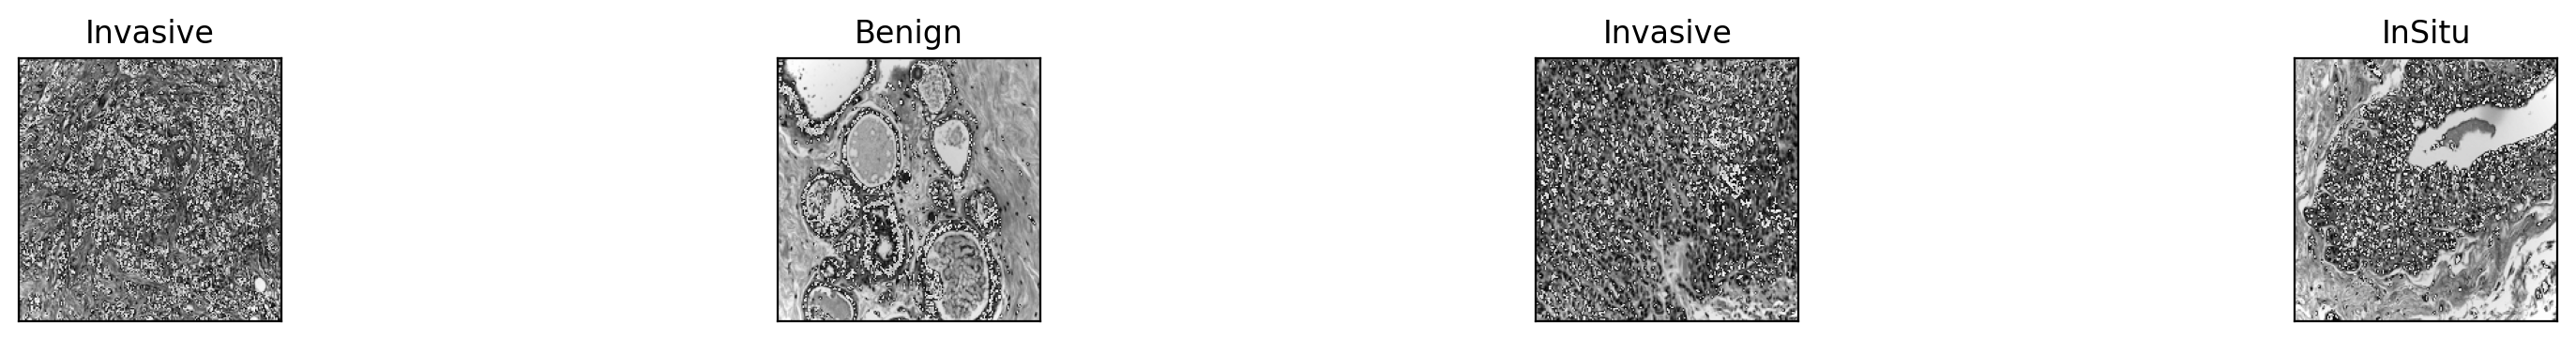

In [129]:
# Um batch de dados de treino
dataiter = iter(dataloader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 8 // 2, idx + 1, xticks=[], yticks=[])  # Correção na divisão
    image = images[idx].numpy().transpose((1, 2, 0))  # Reorganize as dimensões da imagem
    image_pil = Image.fromarray((image * 255).astype(np.uint8))  # Converte para objeto PIL
    plt.imshow(image_pil)  # Exibe a imagem PIL
    ax.set_title(classes[labels[idx]])

plt.show()

In [130]:
cnn = CNN()
cnn.load_state_dict(torch.load(model_path + file_name))

<All keys matched successfully>

In [131]:
outputs = cnn(images)
outputs

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))



Predicted:  Invasive Benign Invasive InSitu


In [132]:
correct = 0
total = 0
# nao precisamos calcular os valores de gradiente pq não estamos treinando
with torch.no_grad():
    for data in dataloader:
        images, labels = data
        outputs = cnn(images)
        # a classe com a maior energia é o que escolhemos como previsão
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 100 %


In [133]:
# contar as previsões para cada classe
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# novamente sem gradientes necessários
with torch.no_grad():
    for data in dataloader:
        images, labels = data
        outputs = cnn(images)
        _, predictions = torch.max(outputs, 1)
        # calcula predições corretas para cada classe
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print acurácia para cada classe
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

# class TestSquare(TestCase): 
#     def test_classe(self): 
#         result = accuracy
#         expected = 90.0
#         self.assertEqual(result, expected)     
#         print(classname, accuracy)
# if __name__ == '__main__':
#     s = unittest.TestLoader().loadTestsFromTestCase(TestSquare)
#   unittest.TextTestRunner().run(s)

 

Accuracy for class Benign is: 100.0 %
Accuracy for class InSitu is: 100.0 %
Accuracy for class Invasive is: 100.0 %
Accuracy for class Normal is: 100.0 %


- Porcentagem % -  método para testar,
para saber a porcentagem para validar se
está acima ou abaixo do limite estipulado

- E quantidade de acertos em número

- Validar se está passando por
todas as imagens

- Validar a acurácia de cada tipo
 ('Benign', 'InSitu', 'Invasive', 'Normal')
e ver qual tipo teve maior acerto


In [134]:
import matplotlib.pyplot as plt
%matplotlib inline

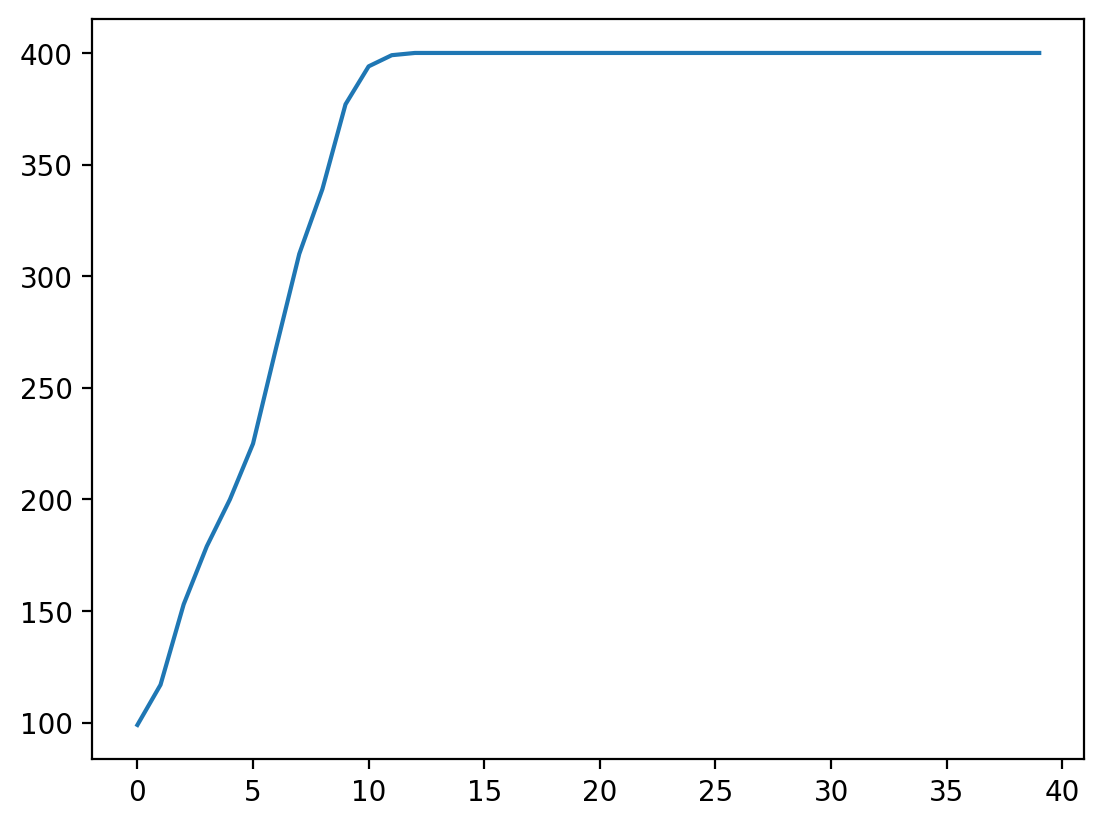

In [135]:
plt.plot(x,y_acertos)
#plt.ylim(bottom=0)
plt.show()

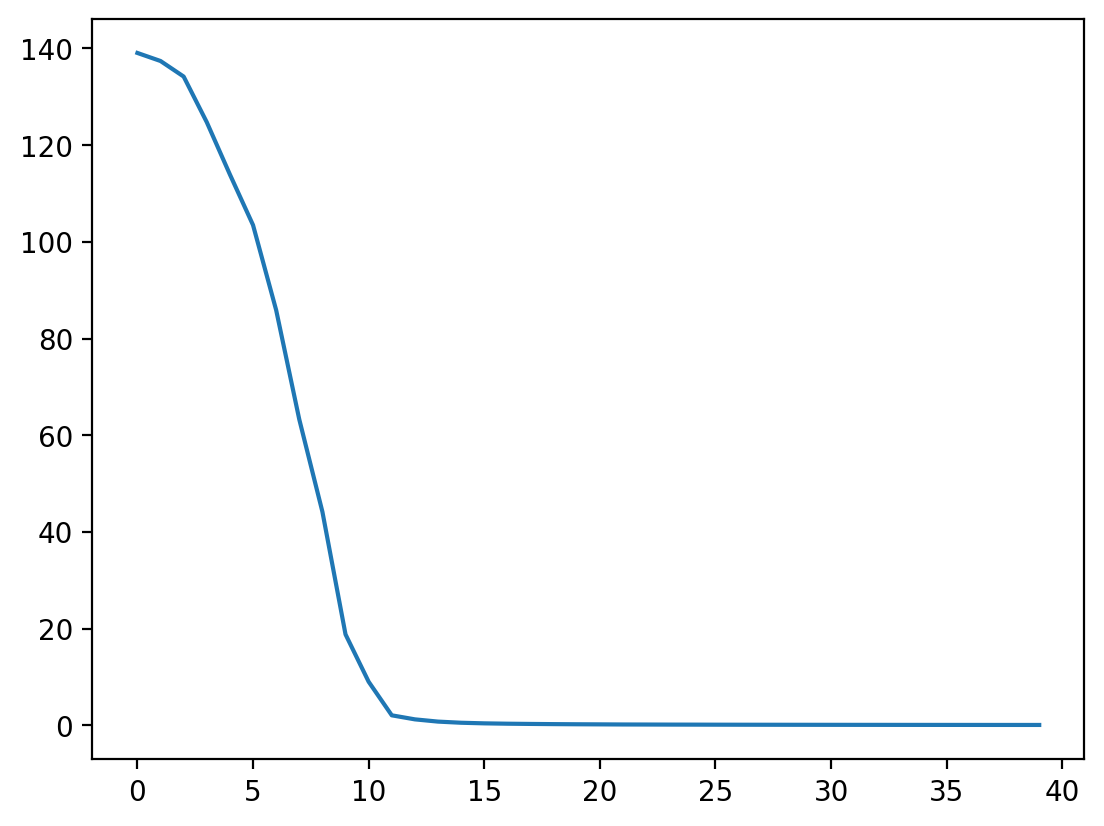

In [136]:
plt.plot(x,y_loss)
#plt.ylim(bottom=0) 
plt.show()

REALIZANDO TESTES

In [137]:
from PIL import Image
import torchvision.transforms as transforms

# image_path = 'C:/Users/Karol/Documents/Python projeto/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/BACH_Preparado/200x200_pb/Normal/n003.tif'
image_path = 'C:/Users/Karol/Documents/Python projeto/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos/Invasive/iv008.tif'

image = Image.open(image_path)

In [138]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),  # Redimensionar para o tamanho de entrada da rede
    transforms.Grayscale(num_output_channels=3),  # Converter para escala de cinza com três canais
    transforms.ToTensor(),  # Converter para tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar
])
input_image = transform(image).unsqueeze(0)  # Adicionar uma dimensão de lote (batch) única

In [139]:
with torch.no_grad():  # Desativar o cálculo de gradientes para economizar memória
    outputs = cnn(input_image)
    _, predicted = torch.max(outputs, 1)

In [140]:
classe_predita = classes[predicted.item()]
print(f'A classe prevista para a imagem é: {classe_predita}')

A classe prevista para a imagem é: Invasive
